In [1]:
import pandas as pd
import numpy as np
import datetime 
import os
import seaborn as sns; sns.set()
import datetime as dt
import collections
import pyplot_themes as themes
import itertools
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from icecream import ic
from nltk.util import bigrams 

# Define functions to use for smoothing, setting plot settings and getting tweet frequencies

In [2]:
def smooth_5000(compound, nroftweets, small):
    if compound:
        if small:
            print("Compound FWHM = 500")
        else:
            print("Compound FWHM = 5000")
    if nroftweets:
        if small:
            print("Nr FWHM = 500")
        else:
            print("Nr FWHM = 5000")
    return 0

def set_base_plot_settings(fontsize, if_palette):
    matplotlib.rc('ytick', labelsize=fontsize)
    matplotlib.rc('xtick', labelsize=fontsize)
    themes.theme_minimal(grid=False, ticks=False, fontsize=fontsize)
    a4_dims = (25,15)
    
    if if_palette:
        #          0 black      1 orange  2 L blue   3 green    4 L orange  5 D blue  6 D orange 7 purple
        palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    else:
        palette = 0
    
    fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
    sns.set(font_scale = 2)

    return fig, ax1, palette

def set_late_plot_settings(if_dates):
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)

    ax1.grid(color='darkgrey', linestyle='-', linewidth=0.5, which= "both")
    if if_dates:
        # Define the date format
        ax1.xaxis_date()
        date_form = mdates.DateFormatter("%d-%b")
        ax1.xaxis.set_major_formatter(date_form)

    ax1.set(ylim=(0, None))
    
    #ax1.set_yticklabels(ax1.get_yticks(), size = 35)

    #fig.suptitle("Mentions of 'vaccin*'. 2020 - 2021", size = "40")
    return fig, ax1

def set_late_barplot_settings():
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)
        
    #ax1.set_yticklabels(ax1.get_yticks(), size = 35)

    #fig.suptitle("Mentions of 'vaccin*'. 2020 - 2021", size = "40")
    return fig, ax1

def get_tweet_frequencies(df):
    # Add freq of tweets by themselves in the dataset
    # pd.DataFrame creates a new datafrme where "number of tweets" is now the column and it is filled with the associated number
    tweet_freq = pd.DataFrame({'nr_of_tweets' : df.groupby(['date']).size()}).reset_index()
    #merge 
    freq_tweets = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    
    return freq_tweets    

def gaussian_kernel(arr, 
                    sigma=False, 
                    fwhm=False):
    """ gaussian kernel smoother for signal arr
    - sigma: standard deviation of gaussian distribution
    - fwhm: full width at half maximum of gaussian distribution
    """
    y_vals = np.array(arr)
    x_vals = np.arange(arr.shape[0])
    if sigma == fwhm:
        print("[INFO] Define parameters \u03C3 xor FWHM")
        pass
    elif fwhm:
        sigma = fwhm / np.sqrt(8 * np.log(2))
    else:
        sigma = sigma
        fwhm = sigma * np.sqrt(8 * np.log(2))
    print("[INFO] Applying Gaussian kernel for \u03C3 = {} and FWHM = {} ".format(round(sigma,2), round(fwhm,2)))
    smoothed_vals = np.zeros(y_vals.shape)
    for x_position in x_vals:
        kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
        kernel = kernel / sum(kernel)
        smoothed_vals[x_position] = sum(y_vals * kernel)
    return smoothed_vals



### Define keyword searched for

In [7]:
data_prefix = "tvang"
map_prefix = f"{data_prefix}_files"

In [8]:
if not os.path.exists("../fig"):
    os.makedirs("../fig")
if not os.path.exists(f"../fig/{data_prefix}"):
    os.makedirs(f"../fig/{data_prefix}")

### Load file and prepare date column

In [21]:
filename = "../" + map_prefix + "/" + data_prefix + "_final.csv"
# filename = "../" + map_prefix + "/restriktion_final.csv"
df = pd.read_csv(filename)
df = df.sort_values("created_at")
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')
df["date"] = pd.to_datetime(df["date"])

In [98]:
#Re-smoothing jul split
# df["split_smooth_compund_200"] = gaussian_kernel(df["centered_compound"], sigma=1, fwhm=200)
# df["split_smooth_compund_500"] = gaussian_kernel(df["centered_compound"], sigma=1, fwhm=500)
# df["split_smooth_nrtweets_200"] = gaussian_kernel(df["nr_of_tweets"], sigma=1, fwhm=200)
# df["split_smooth_nrtweets_500"] = gaussian_kernel(df["nr_of_tweets"], sigma=1, fwhm=500)

[INFO] Applying Gaussian kernel for σ = 84.93 and FWHM = 200 
[INFO] Applying Gaussian kernel for σ = 212.33 and FWHM = 500 
[INFO] Applying Gaussian kernel for σ = 84.93 and FWHM = 200 
[INFO] Applying Gaussian kernel for σ = 212.33 and FWHM = 500 


### Pick start date for tweets - optinal

In [22]:
start_date = "2021-01-01" #datetime.date(2021, 1, 1)
df = df[df['date'] >= start_date]

In [29]:
# Count number of tweets per search keyword
# df.groupby("search_keyword").count()
#Total number of tweets
df.head()
# len(df.index)

,Unnamed: 0,created_at,id,text,search_keyword,date,mentioneless_text,text50,dupe50,emotional,...,s200_compound,s200_nr_of_tweets,s500_compound,s500_nr_of_tweets,date_ordinal,hashtags,tokens_list,tokens_string,nr_of_tweets,Week
0,1159,2021-01-01 01:07:41,1.344813e+18,@SorenSchifter @KVarming Tvang er godt i nazi ...,['tvang'],2021-01-01,Tvang er godt i nazi Tyskland,Tvang er godt i nazi Tyskland,False,Emotional,...,0.078203,27.147633,0.048605,33.046876,737791,[],"['tvinge', 'nazi', 'tyskland']",tvinge nazi tyskland,45,53
1,1160,2021-01-01 01:30:54,1.344818e+18,@SoerenRadoor @PSkipperEL Det er jo ikke på de...,['tvang'],2021-01-01,Det er jo ikke på de psykiatriskeafdelinger ...,Det er jo ikke på de psykiatriskeafdelinger ...,False,Emotional,...,0.078103,27.250328,0.048405,33.104435,737791,[],"['psykiatriskeafdelinger', 'ske', 'ske', 'sted...",psykiatriskeafdelinger ske ske sted geare hånd...,45,53
2,1161,2021-01-01 01:31:46,1.344819e+18,@Peter_R_Hansen @StabellBenn I fht. hendes sna...,['tvang'],2021-01-01,"I fht. hendes snak om tvangsvaccination, er ...","I fht. hendes snak om tvangsvaccination, er ...",False,Emotional,...,0.077997,27.353010,0.048205,33.162215,737791,[],"['fht', 'snak', 'tvangsvaccination', 'konspira...",fht snak tvangsvaccination konspirationsfolket...,45,53
3,1162,2021-01-01 11:24:23,1.344968e+18,@ConnieTtcher @Lemberg @Thorsen_Mark Hov Mikae...,['tvang'],2021-01-01,"Hov Mikael, der glemte du vidst lige at den...","Hov Mikael, der glemte du vidst lige at den...",False,Emotional,...,0.077885,27.455671,0.048004,33.220214,737791,[],"['hov', 'mikael', 'glemme', 'led', 'kritisere'...",hov mikael glemme led kritisere perfekt aldrid...,45,53
4,1163,2021-01-01 12:25:16,1.344983e+18,Dronningen takkede i sin tale politi og militæ...,['tvang'],2021-01-01,Dronningen takkede i sin tale politi og militæ...,Dronningen takkede i sin tale politi og militæ...,False,Emotional,...,0.077768,27.558306,0.047803,33.278431,737791,"['#Trumpine', '#dkpol', '#nytårstale']","['dronning', 'takke', 'tale', 'politi', 'milit...",dronning takke tale politi militær indsats for...,45,53


### Get the frequencies of tweets summed over days

In [23]:
df = get_tweet_frequencies(df.drop("nr_of_tweets", axis=1))

# Plotting tweet frequency over time

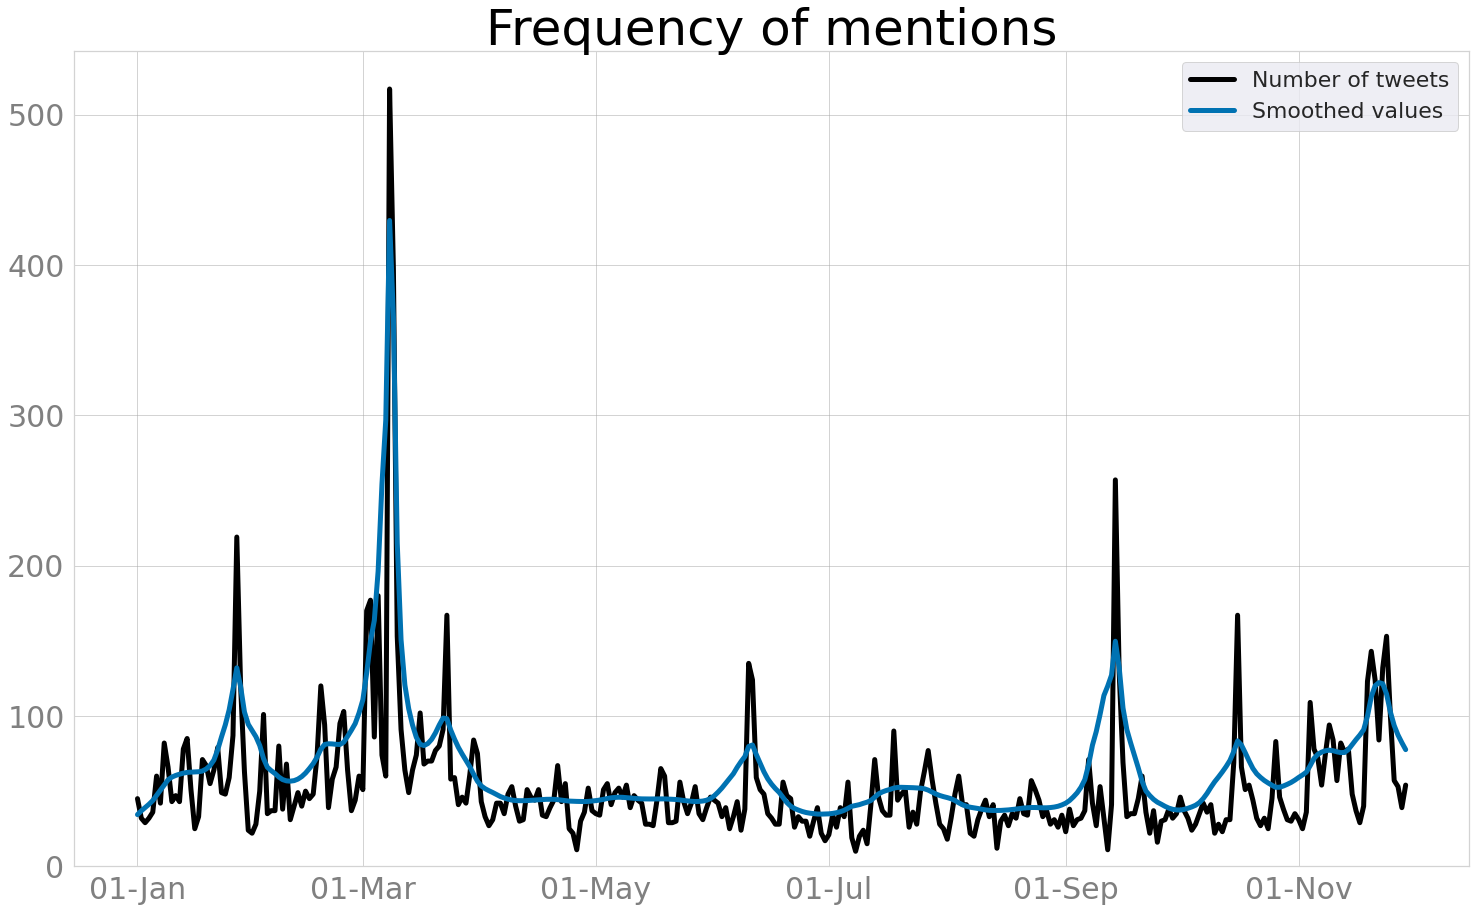

In [25]:
smoothing_value = 500
save = True

fig, ax1, palette = set_base_plot_settings(fontsize=30, if_palette = True)

ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   #alpha = 0.30,
                     linewidth = 5, data = df)

ax1 = sns.lineplot(x="date", y=f"s{smoothing_value}_nr_of_tweets", 
                  color = palette[5], 
                     linewidth = 5, data = df)

# For jul split
# ax1 = sns.lineplot(x="date", y=f"split_smooth_nrtweets_{smoothing_value}", 
#                   color = palette[5], 
#                      linewidth = 5, data = df)



fig, ax1 = set_late_plot_settings(if_dates = True)
plt.legend(labels=['Number of tweets', "Smoothed values"])
ax1.set_title("Frequency of mentions", fontdict = {'fontsize':50}, color = "Black")

plot_name = f"../fig/{data_prefix}/{data_prefix}_freq_{smoothing_value}.png"
if save:
    fig.savefig(plot_name)

fig.show()

# Sentiment over time

### Sum over week instead of day

In [26]:
df["Week"] = df["date"].dt.strftime('%V')

/home/stine/.virtualenvs/hope/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/stine/.virtualenvs/hope/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


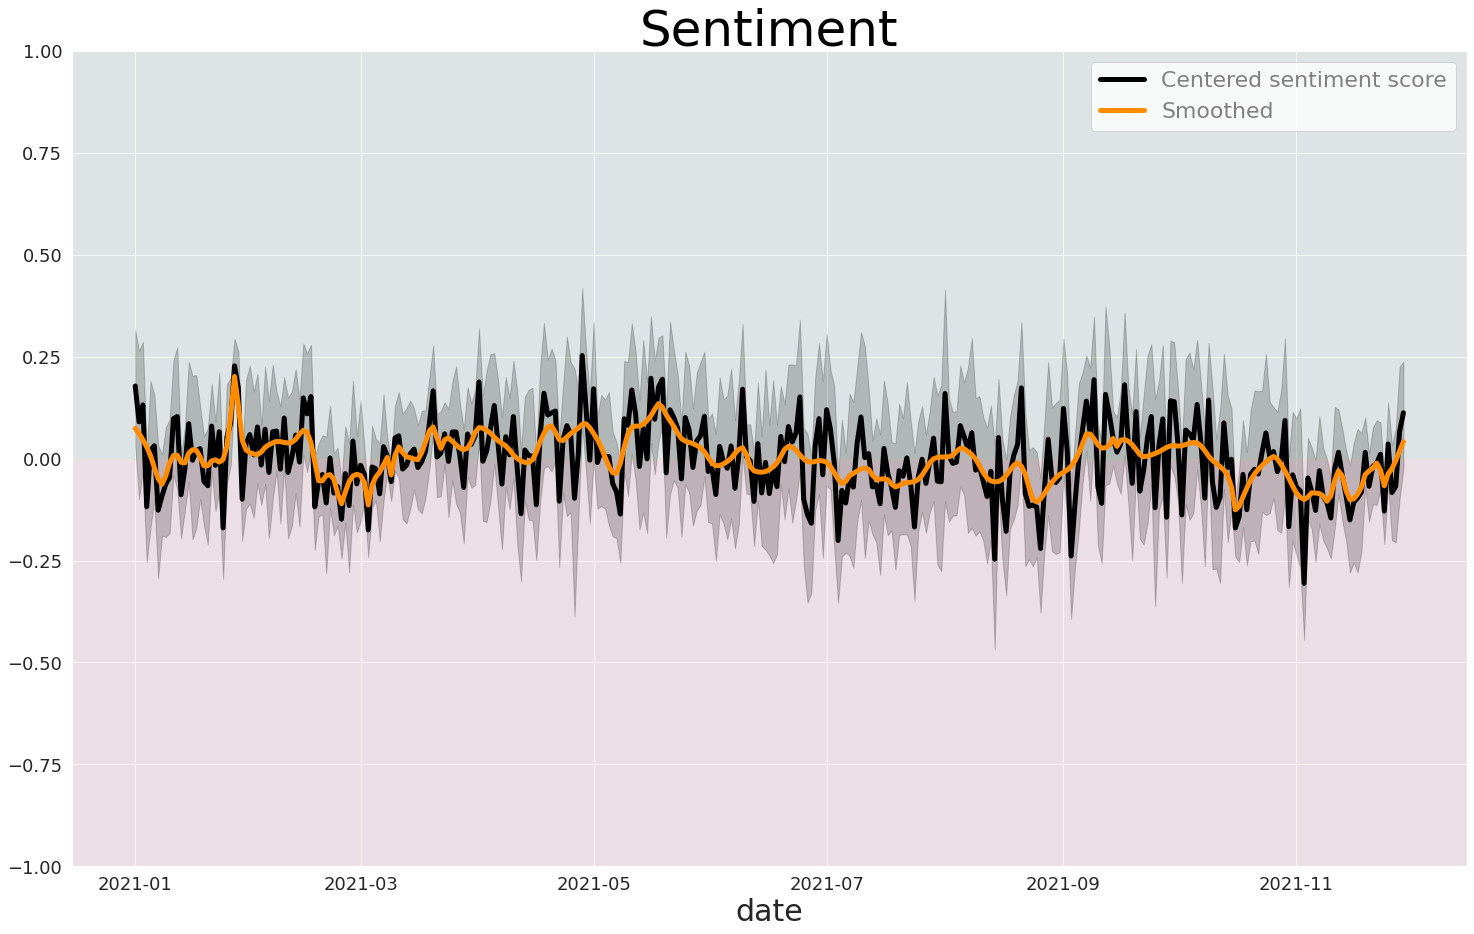

In [27]:
time_scale = "date" #use "Week" or "date"
smoothing_value = 200
save = True

fig, ax1 = plt.subplots(1,1, figsize = (25,15))
themes.theme_minimal(grid=True, ticks=True, fontsize=30)

ax1 = sns.lineplot(x=time_scale, y="centered_compound", 
                  color = "Black", 
                   #alpha = 0.30,
                     linewidth = 5, data = df)

ax1 = sns.lineplot(x=time_scale, y=f"s{smoothing_value}_compound", 
                 color = "darkorange", 
                    linewidth = 5, data = df)

# For jul split
# ax1 = sns.lineplot(x=time_scale, y=f"split_smooth_compund_{smoothing_value}", 
#                  color = "darkorange", 
#                     linewidth = 5, data = df)

ax1.set_ylim(ymin = -1, ymax = 1)
ax1.set(xlabel=time_scale, ylabel = "")
ax1.xaxis.get_label().set_fontsize(30)
ax1.yaxis.get_label().set_fontsize(30)
plt.legend(labels=['Centered sentiment score', 'Smoothed'])
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)

plt.axhspan(0, 1, color = "green", facecolor='0.1', alpha=0.05)
plt.axhspan(0, -1, color = "red", facecolor='0.', alpha=0.05)

ax1.set_title("Sentiment", fontdict = {'fontsize':50}, color = "Black")

plot_name = f"../fig/{data_prefix}/{data_prefix}_sentiment_{time_scale}.png"
if save:
  fig.savefig(plot_name)

fig.show()

# Hashtags

In [14]:
import re

def extract_hashtags(row):
    unique_hashtag_list = list(re.findall(r'#\S*\w', row["text"]))
    return unique_hashtag_list

def hashtag_per_row(data):
    # Create hashtags column with the actual unique hashtags
    data["hashtags"] = data.apply(lambda row: extract_hashtags(row), axis = 1)

    # Let's take a subset of necessary columns, add id
    df = data[["date", "hashtags"]].reset_index().rename(columns={"index": "id"})

    # Select only the ones where we have more than 1 hashtag per tweet
    df = df[df["hashtags"].map(len) > 1].reset_index(drop=True)

    # Hashtag per row
    # convert list of pd.Series then stack it
    df = (df
     .set_index(['date','id'])['hashtags']
     .apply(pd.Series)
     .stack()
     .reset_index()
     .drop('level_2', axis=1)
     .rename(columns={0:'hashtag'}))
    #lowercase!
    df["hashtag"] = df["hashtag"].str.lower()
    df["hashtag"] = df["hashtag"].str.replace("'.", "")
    df["hashtag"] = df["hashtag"].str.replace("’.", "")

    return df

# Aggregate a frequency DF
def get_hashtag_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_hashtags' : df.groupby(['hashtag']).size()}).reset_index()
    return tweet_freq

In [58]:
hashtags = hashtag_per_row(df)
freq_hashtags = get_hashtag_frequencies(hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)
df0 = df1.nlargest(30, columns=['nr_of_hashtags'])

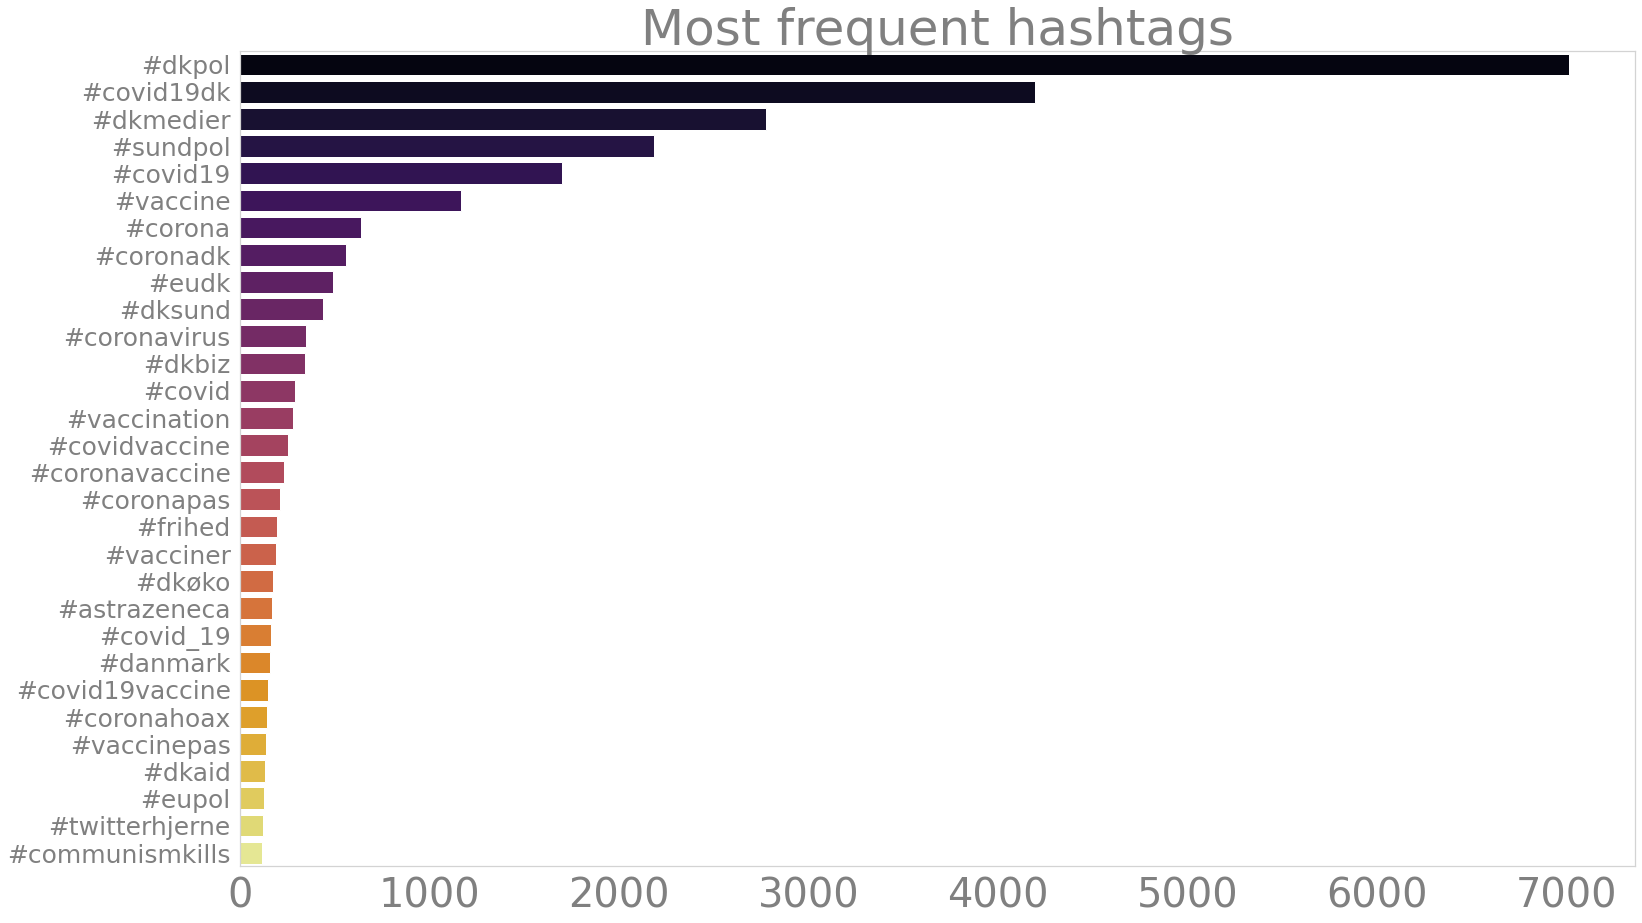

In [59]:
save = True

#Setup
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
themes.theme_minimal(grid=False, ticks=False, fontsize=40)
a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

nr_hash = len(df0["hashtag"].unique())
palette = sns.color_palette("inferno", nr_hash)

#Plot
ax = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = palette, data = df0)

#Axes
ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = f"../fig/{data_prefix}/{data_prefix}_frequent_hashtags.png"
if save:
    fig.savefig(plot_name)

# Most frequent words

In [17]:
import spacy
import string
from string import digits
import re

In [60]:
sp = spacy.load('da_core_news_lg')

file = open("../src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

In [73]:
# keyword_list = ["delta variant", 
#                 "delta-variant", 
#                 "deltavariant", 
#                 "variant", 
#                 "mutation", 
#                 "vaccin", 
#                 "coronapas", 
#                 "mundbind", 
#                 "mettef", 
#                 "mette f", 
#                 "statsminister", 
#                 "statminister", 
#                 "corona", 
#                 "covid", 
#                 "restriktion", 
#                 "tvang", 
#                 "samfundskri", 
#                 "omicron", 
#                 "sydafrikansk variant", 
#                 "sydafrikanske variant", 
#                 "b.1.1.529", 
#                 "b11529", 
#                 "omikron"]

In [61]:
texts = df["tokens_string"]
word_freq = df.tokens_string.str.split(expand=True).stack().value_counts()
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})
df0 = word_freq.nlargest(30, columns=['Frequency'])

In [91]:
# For split dataframe
# covid_subset = word_freq[word_freq["word"].isin(keyword_list)]
# df0 = covid_subset.nlargest(len(covid_subset), columns=['Frequency'])

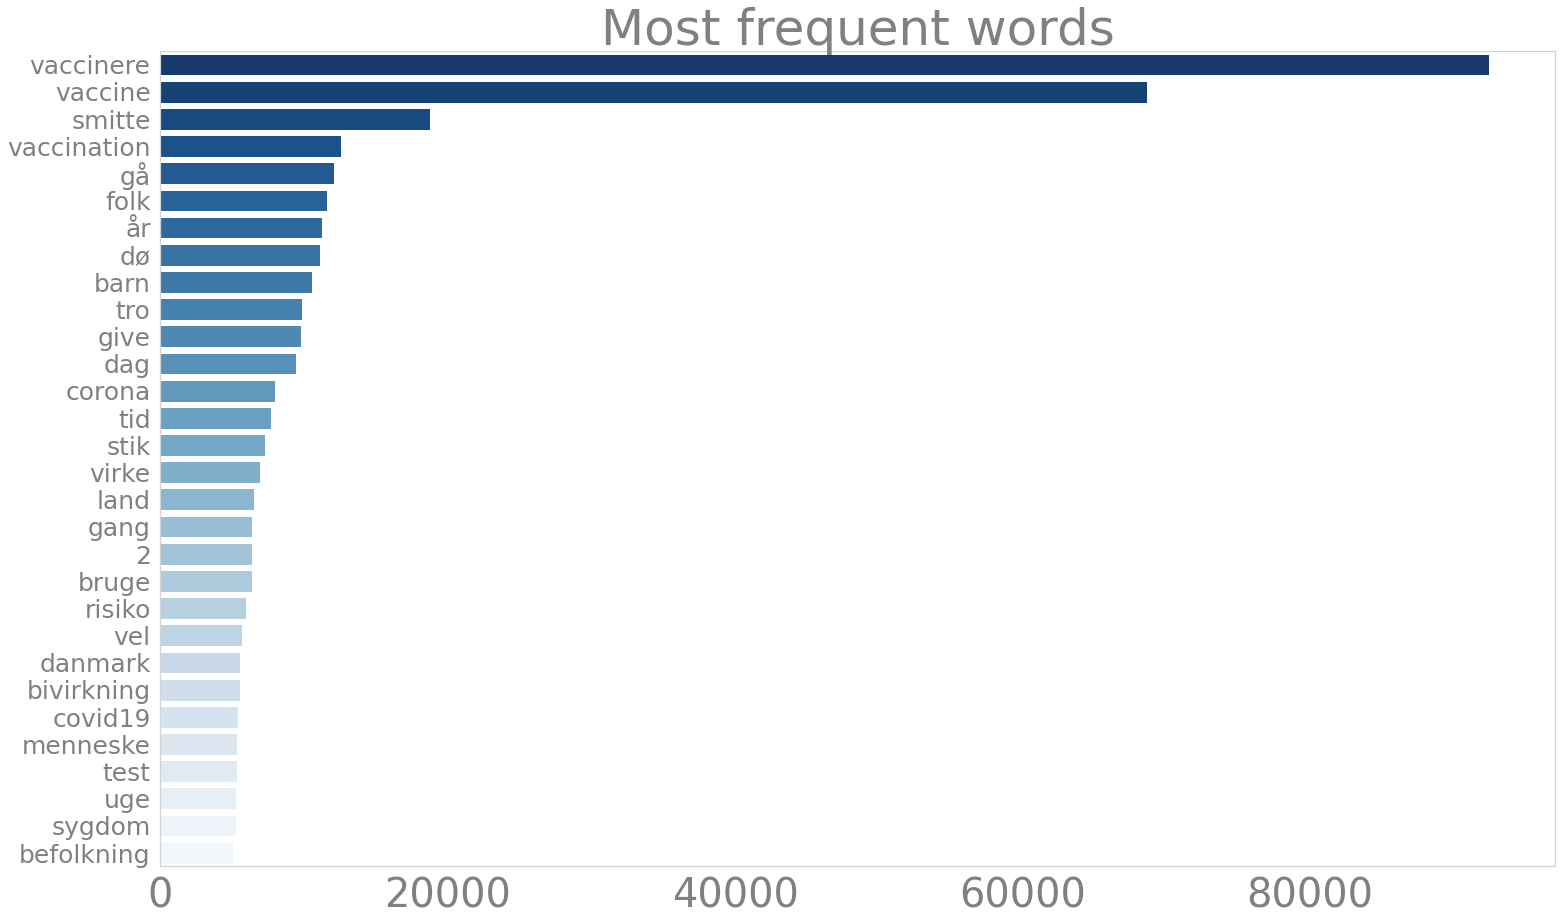

In [62]:
save = True
#Prepare plot
matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)
themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

n_words = len(df0["word"].unique())
palette = sns.color_palette("Blues_r", n_words)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = f"../fig/{data_prefix}/{data_prefix}_word_frequency.png"
if save:
    fig.savefig(plot_name)

# Bigrams

In [21]:
import ast
from nltk.util import bigrams
import itertools
import collections
import networkx as nx

In [63]:
terms_bigram = [list(bigrams(ast.literal_eval(tweet))) for tweet in df['tokens_list']]
# Flatten list of bigrams in clean tweets
bigrms = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrms)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

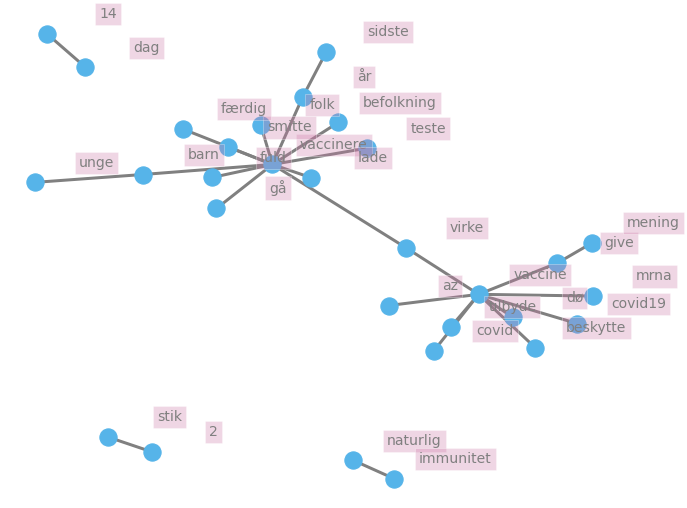

In [66]:
save = True
k = 5
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
scale_nodes = False

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for key, value in d[0].items():
    G.add_edge(key[0], key[1], weight=(value * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=k)

# Nodes
d = word_freq.to_dict(orient = 'split')['data']
d = [(int(word[1]))*2 for node in G.nodes() for word in d if word[0] == node]

if scale_nodes:
    # Plot networks
    nx.draw_networkx(G, pos,
                    font_size=10,
                    width=3,
                    edge_color= "grey",#palette[0], #'red',
                    node_color= palette[2], #'green',
                    node_size = d,
                    with_labels = False,
                    ax=ax)
else:
    nx.draw_networkx(G, pos,
                    font_size=10,
                    width=3,
                    edge_color= "grey",#palette[0], #'red',
                    node_color= palette[2], #'green',
                    with_labels = False,
                    ax=ax)
# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

if save and scale_nodes:
    plt.savefig(f"../fig/{data_prefix}/{data_prefix}_bigram_graph_scaled.png", dpi=150)
else:
    plt.savefig(f"../fig/{data_prefix}/{data_prefix}_bigram_graph.png", dpi=150)

plt.show()

# Wordcloud

In [29]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes
from wordcloud import WordCloud, STOPWORDS
import string

In [68]:
# texts = ", ".join(texts)
# texts = texts.translate(str.maketrans('', '', string.punctuation))
# texts = texts.lower()
texts = df["tokens_string"]
texts = texts[texts.notnull()] #Sometimes necessary
texts = ", ".join(texts)

In [31]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, save=False):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = f"../fig/{data_prefix}/{data_prefix}_word_cloud.png"
    if save:
        plt.savefig(plot_name)

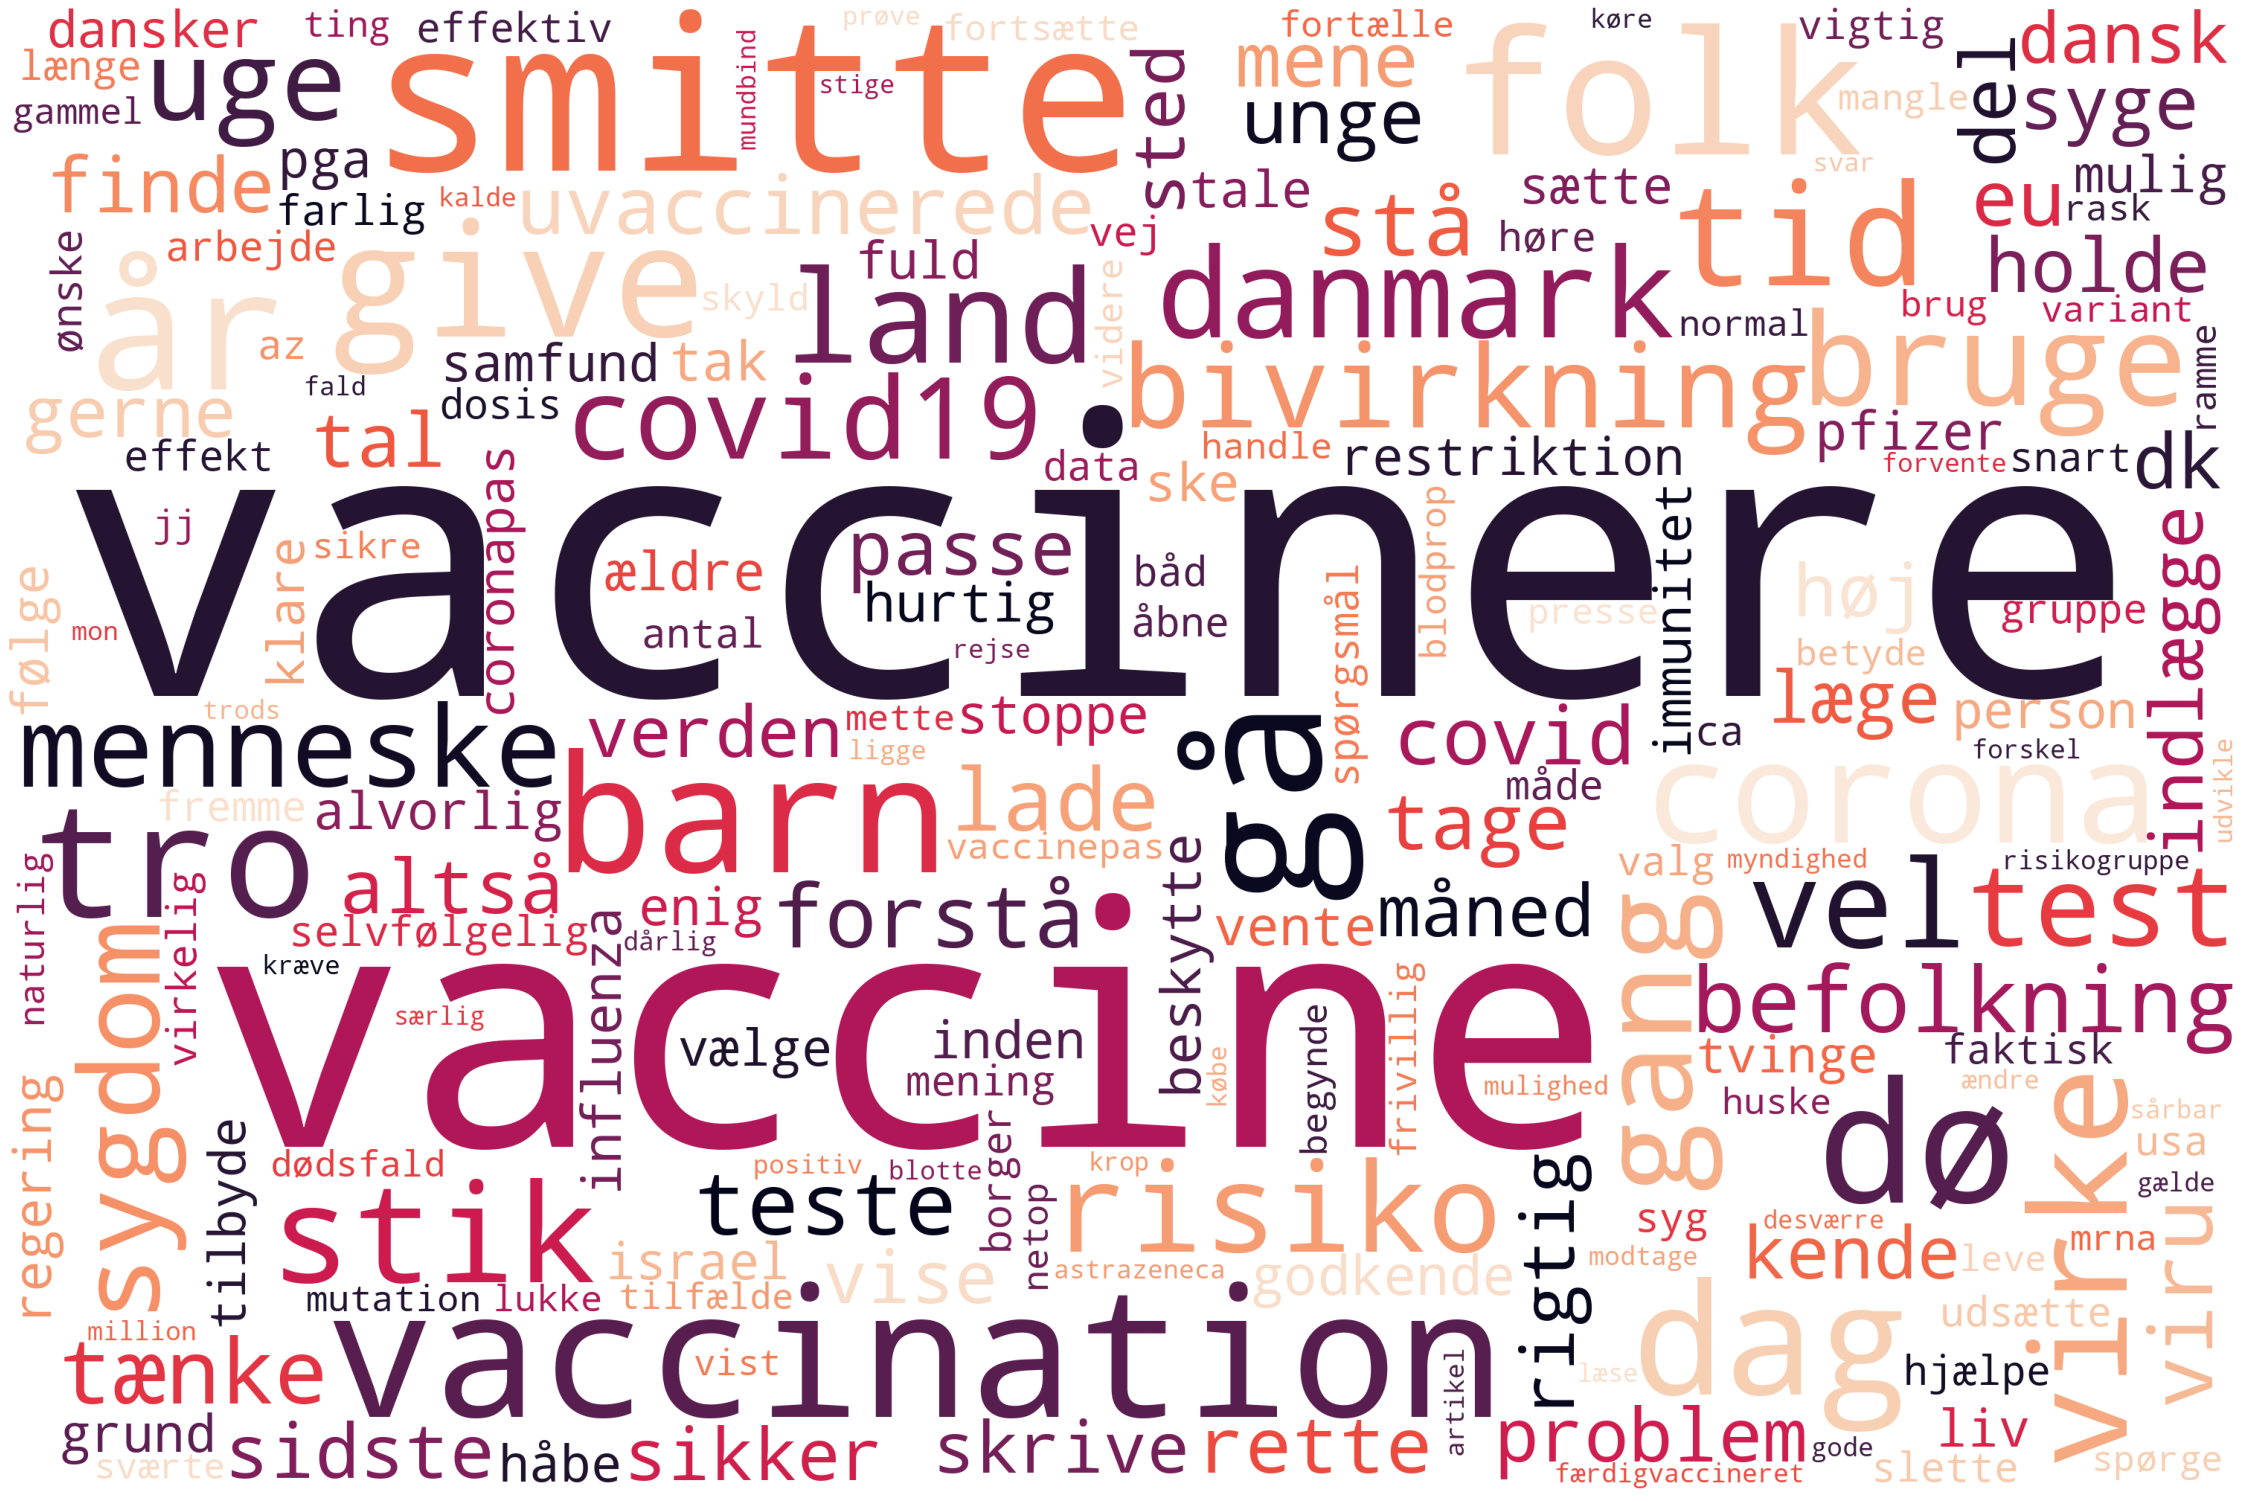

In [69]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = my_stop_words).generate(texts)
# Plot
plot_cloud(wordcloud, save=True)